In [1]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.primitives import Estimator
from qiskit_machine_learning.connectors import TorchConnector
import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
import pandas as pd

from Components.train import create_qnn, sampling_experiment, train, train_batch
from Components.data import cancer_data
from Components.circuits import *

from GLOBAL_CONFIG import *

In [2]:
X_train, X_val, y_train, y_val = cancer_data(PCA_n = FEATURE_DIM)
# X_train, X_val, y_train, y_val = fetch_mnist(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = iris(pd=False, PCA_n=None)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

Training set: 398 samples
Testing set: 171 samples
Number of features: 4
Classes:[0 1]; Encoded as: [-1  1]


Number of params: 40


/Users/ncng/.local/share/virtualenvs/VQA-Notes-v2-RAzj5USt/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


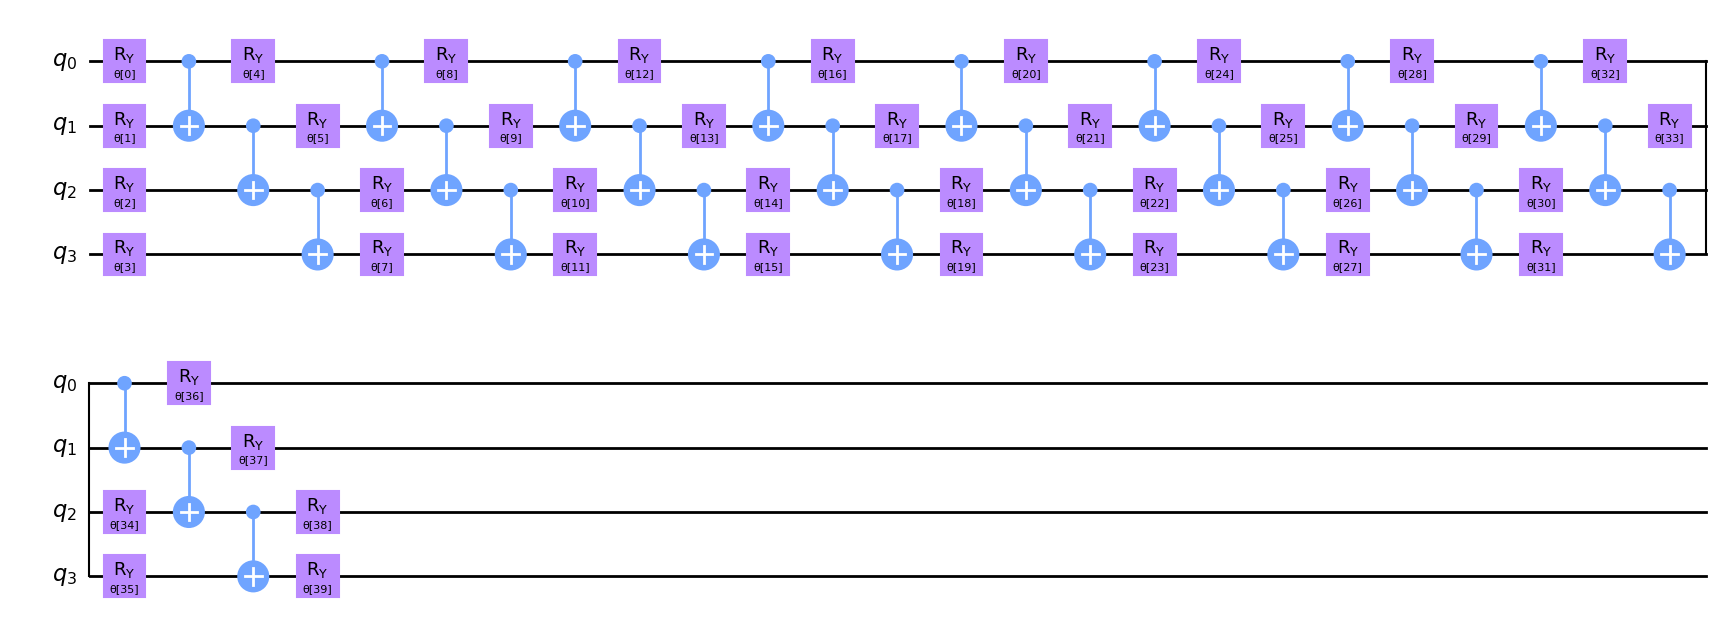

In [3]:
normal_circuit = AnsatzGenerator(num_qubits=FEATURE_DIM, reps=MAX_REPS, entanglement=ENTANGLEMENT)
print(f'Number of params: {normal_circuit.num_parameters_settable}')
normal_circuit.decompose().draw('mpl')

Number of params: 40


/Users/ncng/.local/share/virtualenvs/VQA-Notes-v2-RAzj5USt/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


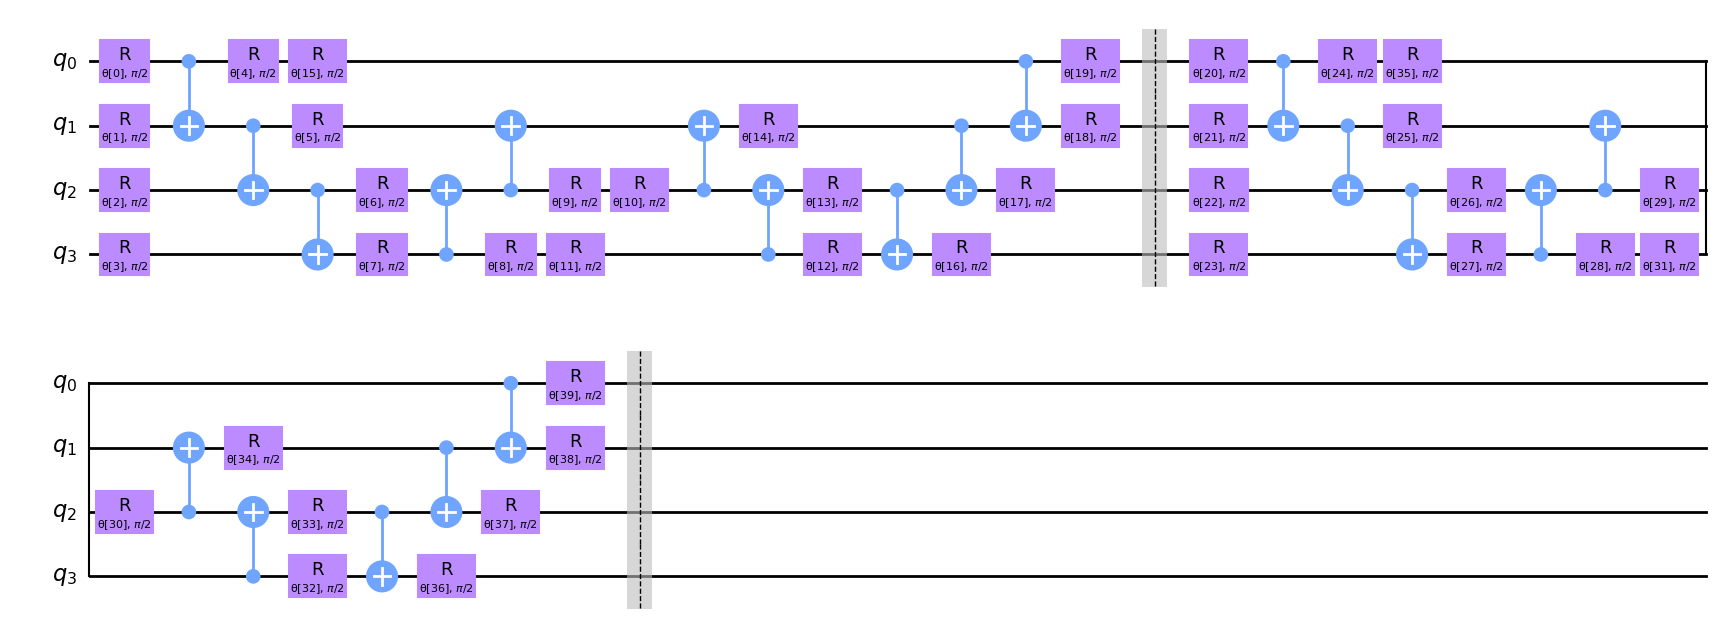

In [4]:
iblock = preTrainedBlockGenerator(num_qubits=FEATURE_DIM, num_blocks=MAX_IDENTITIES_BLOCKS, overlay=2)
params = iblock['params_values']
print(f'Number of params: {len(params)}')
iblock['circuit'].decompose().draw('mpl')

range(9, 5)


/Users/ncng/.local/share/virtualenvs/VQA-Notes-v2-RAzj5USt/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


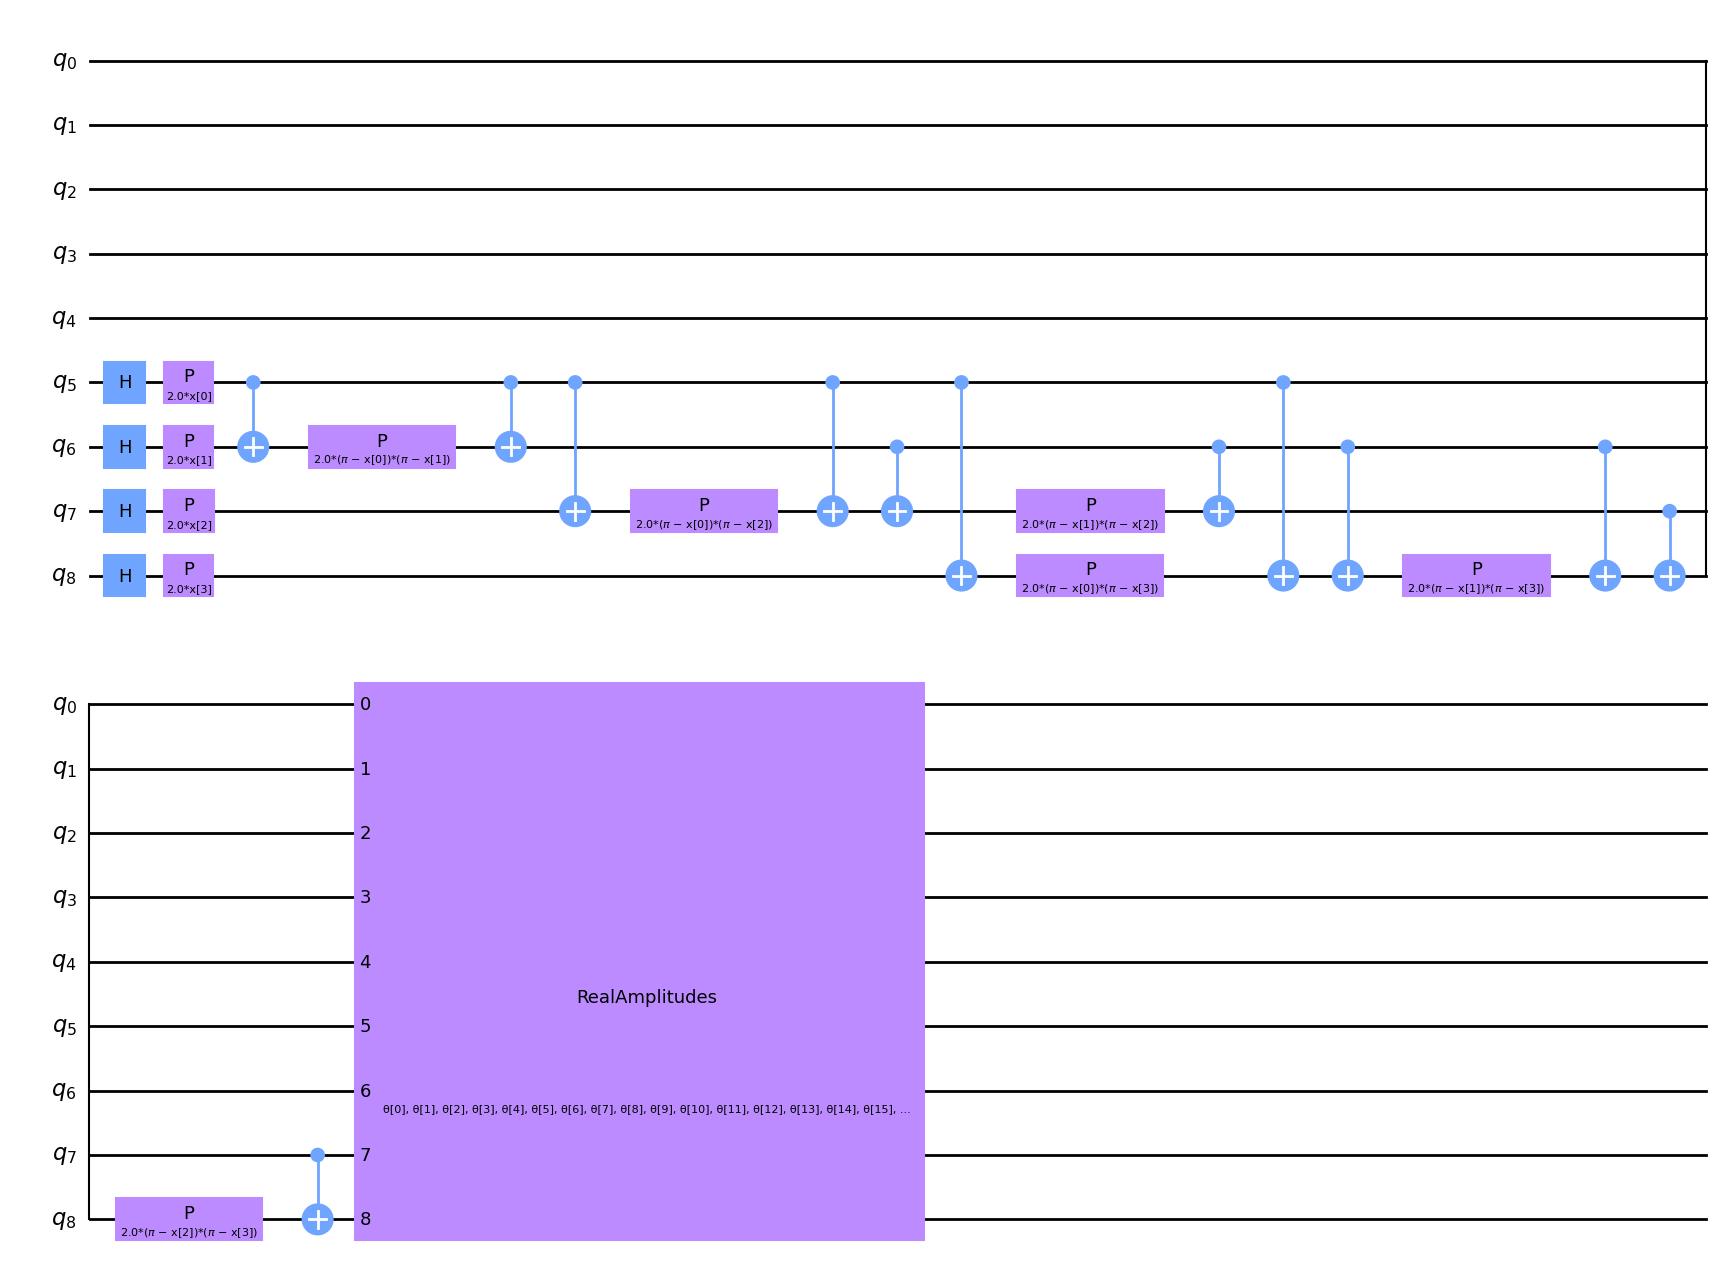

In [12]:
feature_map = featureMapGenerator(FEATURE_DIM)
ansatz = AnsatzGenerator(MAX_QUBITS, MAX_REPS, ENTANGLEMENT)

experimental_qc = circuitBuilder(feature_map, ansatz, 'bottom')
experimental_qc.decompose().draw('mpl')

In [13]:
qnn = EstimatorQNN(
    circuit=experimental_qc,
    estimator=Estimator(),
    observables=GLOBAL_OPERATOR,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters
)

In [14]:
model = TorchConnector(qnn)
loss_function = nn.L1Loss() # nn.MSELoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

model, losses, accuracy_train, accuracy_test, weights = train(
    model, 
    10, 
    X_train_t,
    y_train_t,
    X_val_t,
    y_val_t,
    optimizer = optimizer, 
    loss_function = loss_function
)

Epoch      Loss                 Train Accuracy   Test Accuracy   


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(8)

data = [pd.DataFrame(accuracy_test).astype('float').T]
# Plot data
for i in range(len(data)):
    data[i].T.plot(ax=ax, label=f'inst# {i}', figsize=(5, 3))
ax.legend([f'inst {i}' for i in range(len(data))])
plt.title('instace losses')
plt.show()  